In [1]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os 
try:
    os.chdir(r'/Users/joan/code/python/jokes-app')
except FileNotFoundError:
    os.chdir(r'/home/repos/joke-app')
    DB_HOST = "watxaut.com"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import src.api.src.db.core as db
try:
    from src.api.src.db.secret import (
        HOST_OVH as DB_HOST, 
        POSTGRES_USER, 
        POSTGRES_PASSWORD_OVH as POSTGRES_PASSWORD, 
        SCHEMA_NAME
    )
except ImportError:
    from src.api.src.db.secret import POSTGRES_USER, POSTGRES_PASSWORD, SCHEMA_NAME

### Get connection to Postgres DB

In [4]:
conn = db.connect(host=DB_HOST, user=POSTGRES_USER, password=POSTGRES_PASSWORD, schema_name=SCHEMA_NAME)

# USERS

### Get Number of subscribed users and unsubscribed users

In [5]:
df = db.execute_read(conn, "select * from users_mail")

In [6]:
n_subbed = df["deleted_at"].isna().sum()
n_unsubbed = len(df) - n_subbed

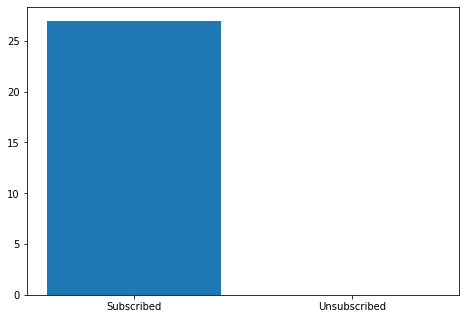

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l_bars = ['Subscribed', 'Unsubscribed']
ax.bar(l_bars, [n_subbed, n_unsubbed])
plt.show()

### Top 10 Joke reviewers

In [15]:
df_mean_user = db.execute_read(conn, """
select 
	um.email, avg(r.rating), count(r)
from 
	ratings as r
left join users_mail as um
on (r.user_id = um.id_hash)
where "source" = 'mail' and um.email is not null
group by um.email
order by count(r.rating) desc
""")

In [16]:
df_mean_user.head(20)

,email,avg,count
0,watxaut@gmail.com,7.590909,66
1,jaime.conde@ficosa.com,1.784483,58
2,irene.chausse@mosaicfactor.com,4.925926,54
3,Javier.heras@volkswagen-groupservices.com,5.807692,52
4,Extern.javier.gris@seat.es,5.098039,51
5,antoni.martinezlopez@ficosa.com,3.930000,50
6,guillem.mcid@gmail.com,6.860000,50
7,adria.hr@gmail.com,4.204082,49
8,ingrid.falguera19@gmail.com,6.860465,43
9,bcocamarin@gmail.com,7.419355,31


## TOP 5 Most Haters (min 5 reviews)

In [17]:
df_mean_user_min_count = df_mean_user[df_mean_user["count"] >= 5]
df_mean_user_hater = df_mean_user_min_count.sort_values(by=['avg', 'count'])
df_mean_user_hater.head(5)

,email,avg,count
1,jaime.conde@ficosa.com,1.784483,58
5,antoni.martinezlopez@ficosa.com,3.930000,50
16,alex.colomer.puig@gmail.com,4.150000,20
7,adria.hr@gmail.com,4.204082,49
17,ponsmonica95@gmail.com,4.550000,20


## TOP 5 Supporters (min 5 reviews)

In [18]:
df_mean_user_supporter = df_mean_user_min_count.sort_values(by=['avg', 'count'], ascending=False)
df_mean_user_supporter.head()

,email,avg,count
12,neuscuadernpuig@gmail.com,8.000000,29
0,watxaut@gmail.com,7.590909,66
9,bcocamarin@gmail.com,7.419355,31
11,leireberrocal6@gmail.com,6.887097,31
19,paucharlez1997@gmail.com,6.875000,16


## TOP JOKE SENDERS

In [19]:
sql = """
select 
    split_part(author_email, '@', 1), count(*) as chistes_sent 
from 
    public.jokes_to_send 
where 
    author is not null and
    author_email is not null 
group by author_email 
order by chistes_sent desc
"""
df_marc_senders = db.execute_read(conn, sql)
df_marc_senders.head(5)

,split_part,chistes_sent
0,Javier.heras,31
1,watxaut,27
2,jaime.conde,17
3,Extern.javier.gris,6
4,alex.colomer.puig,6


# USERS

## AVG joke rating per user

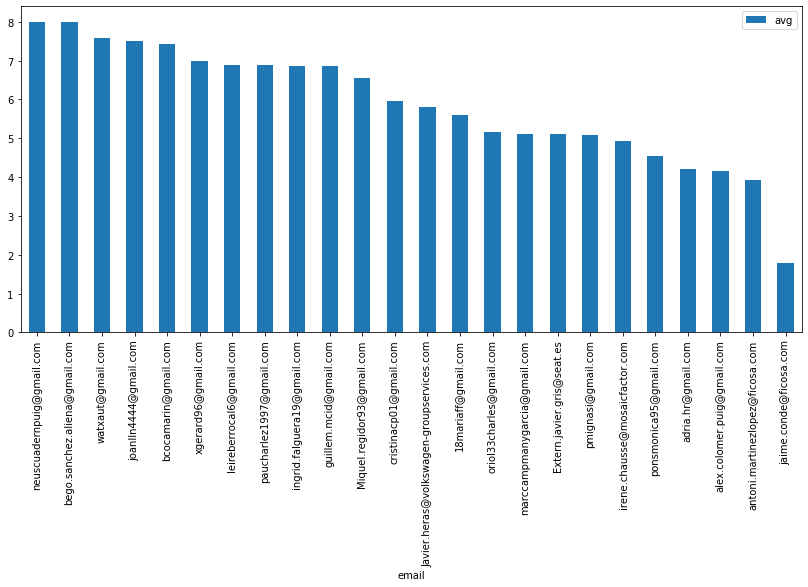

In [29]:
df_mean_user.sort_values(by=['avg'], ascending=False).plot.bar(x="email", y="avg", figsize=(14, 6))

### Rating Statistics

In [26]:
sql = """
select 
	sj.joke_id, r.rating, date(sj.created_at) as day, r.created_at as voted_at
from
	sent_jokes as sj
left join 
	ratings as r
on 
	(r.joke_id = sj.joke_id)
where 
	r."source" = 'mail' and sj.sent_from = 'mail'
order by sj.created_at asc
"""
df_ratings = db.execute_read(conn, sql)
df_sent_mails = db.execute_read(conn, "select joke_id, date(created_at) as day from sent_jokes where sent_from = 'mail'")

#### Get last 10 ratings

In [27]:
df_ratings.tail(15)

,joke_id,rating,day,voted_at
749,1830,10.0,2020-01-17,2020-01-17 07:31:53.478665
750,1830,0.0,2020-01-17,2020-01-17 07:30:25.875198
751,1830,10.0,2020-01-17,2020-01-17 07:30:31.185863
752,1830,0.0,2020-01-17,2020-01-17 08:48:35.049835
753,1830,6.0,2020-01-17,2020-01-17 08:39:36.172635
754,1830,2.0,2020-01-17,2020-01-17 07:31:47.692359
755,1830,8.0,2020-01-17,2020-01-17 07:31:44.230047
756,1830,7.0,2020-01-17,2020-01-17 07:31:24.552564
757,1830,7.0,2020-01-17,2020-01-17 07:30:54.808807
758,1830,8.0,2020-01-17,2020-01-17 07:39:02.124086


## Get mean of ratings by joke and day

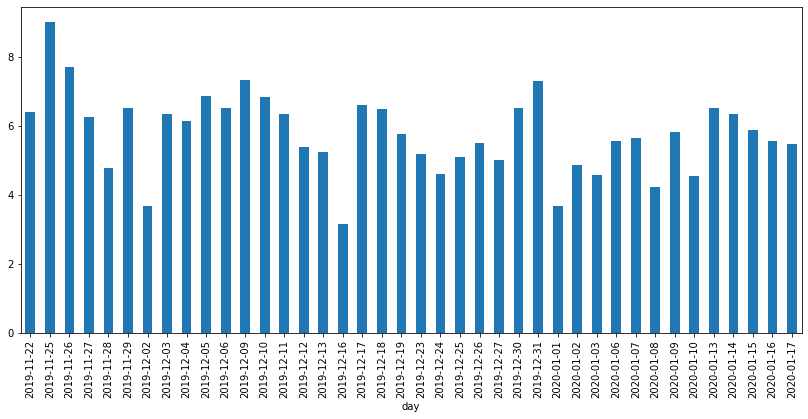

In [31]:
mean_ratings = df_ratings.groupby(["day"])["rating"].mean()
mean_ratings.tail(40).plot.bar(x="day", y="rating", figsize=(14, 6))

## Get Std Deviation of ratings by joke and day

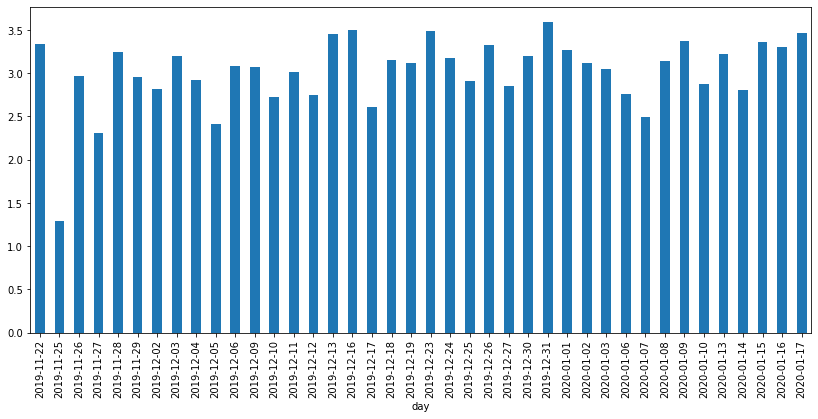

In [32]:
std_ratings = df_ratings.groupby(["day"])["rating"].std()
std_ratings.tail(40).plot.bar(x="day", y="rating", figsize=(14, 6))

In [93]:
df_count_ratings = df_ratings.rename(columns={"rating": "count"}).groupby(["day"])["count"].count()
mean_ratings = pd.concat([mean_ratings, df_count_ratings], axis=1)
mean_ratings = mean_ratings[mean_ratings["count"] > 5]

std_ratings = pd.concat([std_ratings, df_count_ratings], axis=1)
std_ratings = std_ratings[std_ratings["count"] > 5]

In [94]:
# add again joke id to table
mean_ratings = mean_ratings.merge(df_sent_mails, on='day')
std_ratings = std_ratings.merge(df_sent_mails, on='day')

In [96]:
# get worst and best joke from mean - date
d_best = mean_ratings.sort_values(ascending=False, by='rating').head(1).to_dict(orient="index")
best_joke_id = list(d_best.values())[0]["joke_id"]
d_worst = mean_ratings.sort_values(ascending=False, by='rating').tail(1).to_dict(orient="index")
worst_joke_id = list(d_worst.values())[0]["joke_id"]

# get most controversial joke date
d_cont = std_ratings.sort_values(ascending=False, by='rating').head(1).to_dict(orient="index")
cont_joke_id = list(d_cont.values())[0]["joke_id"]

df_best = db.execute_read(conn, f"select * from jokes_to_send where id = {best_joke_id}")
df_worst = db.execute_read(conn, f"select * from jokes_to_send where id = {worst_joke_id}")
df_cont = db.execute_read(conn, f"select * from jokes_to_send where id = {cont_joke_id}")

## Best joke of all time

In [97]:
print(f"Joke:\n{df_best['joke'][0]}\nAuthor: {df_best['author'][0]}")

Joke:
— ¿Qué es un pez en un cine?

— Un mero espectador
Author: Jokenasi


## Worst joke of all time

In [98]:
print(f"Joke:\n{df_worst['joke'][0]}\nAuthor: {df_worst['author'][0]}")

Joke:
Estos son Zidane i Nhug, nuestros perros de caza... 
.... de caza nueztra.
Author: None


## Most controversial of all time

In [99]:
print(f"Joke:\n{df_cont['joke'][0]}\nAuthor: {df_cont['author'][0]}")

Joke:
¿En qué se parecen un gato, un perro y un hombre ahogado?
En que el gato dice miau, el perro dice guau y el hombre dice: miauguau
Author: The Manlleus
